# Test LT maps

### Author: JJGC

### Software: KrCalib : https://github.com/nextic/KrCalib/

In [1]:
%load_ext autoreload
%autoreload 2
import os
import time
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Sun Oct  7 15:14:02 2018


In [2]:
import logging
import sys

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

logging.info('Hello world!')



2018-10-07 15:14:03,628 | INFO : Hello world!


In [3]:
from krcal.core.kr_types import KrFileName
input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"

input_file_names  = ['dst_6284_trigger1_0000_7920.h5']
output_file_name  = ' '
map_file_name     = ' '
map_file_name_ts  = ' '
emap_file_name    = ' '


krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [5]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings
sns.set()

### Imports from IC

In [6]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from krcal.core.core_functions      import time_delta_from_time
from krcal.core.core_functions      import phirad_to_deg
from krcal.core.core_functions      import NN
from krcal.core                     import fit_functions_ic as fitf

In [7]:
from krcal.core.io_functions       import kdst_write
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_maps_ts
from krcal.core.io_functions       import read_maps_ts

In [8]:
from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo

In [9]:
from krcal.core.analysis_functions  import kr_ranges_and_bins
from krcal.core.analysis_functions  import fiducial_volumes
from krcal.core.analysis_functions  import fid_eff
from krcal.core.analysis_functions  import select_rphi_sectors
from krcal.core.analysis_functions  import select_xy_sectors
from krcal.core.analysis_functions  import event_map
from krcal.core.analysis_functions  import plot_sector
from krcal.core.analysis_functions  import plot_sectors
from krcal.core.analysis_functions  import kr_event_selection
from krcal.core.analysis_functions  import kr_event

In [10]:
from krcal.core.fit_lt_functions    import fit_lifetime
from krcal.core.fit_lt_functions    import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_functions    import print_fit_lifetime
from krcal.core.fit_lt_functions    import time_fcs
from krcal.core.fit_lt_functions    import fit_fcs_in_sectors
from krcal.core.fit_lt_functions    import fit_fcs_in_xy_bin
from krcal.core.fit_lt_functions    import fit_map
from krcal.core.fit_lt_functions    import fit_map_xy
from krcal.core.fit_lt_functions    import get_time_series

In [11]:
from krcal.core.fit_lt_histograms   import histo_fit_sectors
from krcal.core.fit_lt_histograms   import print_fit_sectors_pars
from krcal.core.fit_lt_histograms   import plot_fit_sectors
from krcal.core.fit_lt_histograms   import plot_fit_xy
from krcal.core.fit_lt_histograms   import plot_time_fcs

In [12]:
from krcal.core.kr_types import PlotLabels, KrEvent, ASectorMap
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core.kr_types import KrFileName

In [13]:
from krcal.core.map_functions   import draw_wedges
from krcal.core.map_functions   import define_rphi_sectors
from krcal.core.map_functions   import rphi_sector_alpha_map
from krcal.core.map_functions   import rphi_sector_map
from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import draw_maps
from krcal.core.map_functions   import amap_valid_mask
from krcal.core.map_functions   import amap_valid_fraction
from krcal.core.map_functions   import draw_xy_maps
from krcal.core.map_functions   import draw_xy_map
from krcal.core.map_functions   import draw_xy_maps_ts
from krcal.core.map_functions   import amap_average
from krcal.core.map_functions   import amap_max
from krcal.core.map_functions   import amap_min
from krcal.core.map_functions   import amap_replace_nan_by_mean
from krcal.core.map_functions   import amap_replace_nan_by_zero
from krcal.core.map_functions   import regularize_maps
from krcal.core.map_functions   import get_maps_from_tsmap
from krcal.core.map_functions   import map_average

In [14]:
from numpy import pi, sqrt

In [15]:
from typing      import List, Tuple, Dict, Sequence, Iterable

In [16]:
from krcal.core.kr_types import PlotLabels
from krcal.core.kr_types import FitType
from krcal.core          import fit_functions_ic as fitf

### logger

In [17]:
log = logging.getLogger()

## Input data

In [18]:
fn =filenames_from_list(krfn, input_path, output_path, map_path)

In [19]:
fn

KrFileName(input_file_names=['/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6284_trigger1_0000_7920.h5'], output_file_name='/Users/jjgomezcadenas/Projects/ICDATA/ldst/ ', map_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/ ', map_file_name_ts='/Users/jjgomezcadenas/Projects/ICDATA/maps/ ', emap_file_name='/Users/jjgomezcadenas/Projects/ICDATA/maps/ ')

In [20]:
fn.input_file_names

['/Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6284_trigger1_0000_7920.h5']

In [21]:
dst           = load_dsts(fn.input_file_names, "DST", "Events")
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {number_of_evts_full}")

Total number of events: 1583342


In [22]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [23]:
dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

### Ranges and binning

In [24]:
RMAX      = 200

s1e_range = (2, 30)
s2e_range = (2000, 14000)
s2q_range = (200, 800)

xy_range  = (-RMAX,  RMAX)
z_range   = (50,  550)
e_range = (5000, 14000)
lt_range = (1000, 5000)
c2_range = (0,3)

krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 10,
                                                        s2enbins  = 25,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

In [25]:
krNbins.X

100

In [26]:
len(krBins.X)

101

In [27]:
kge = kr_event(dst, DT, dst.S2e, dst.S2q)

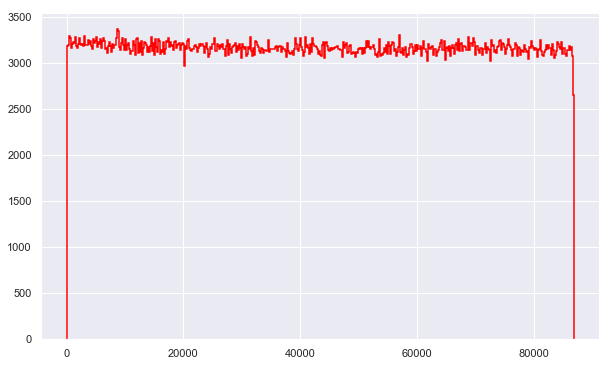

In [28]:
fig = plt.figure(figsize=(10,6))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(kge.DT, bins=500, range = (kge.DT[0], kge.DT[-1]), color='red', stats=False, lbl='pre-sel')

## Tests

#### Function: 
```
def get_time_series(nt    : int,
                    tlast : int,
                    KRES  : KrEvent)->Tuple[List[float], List[np.array]]:
```

Returns a time series (ts) and a list of masks which are used to divide the event in time tranches.

    - nt:    number of time tranches requested
    - tlast: last time entry in the time-differences vector that keeps the length of the run in terms of time-differences wrt the initial time.
    - KRES:  An object of type kr_event (a subsection of the dst)

In [29]:
log.setLevel(logging.INFO)

In [30]:
nt = 10
t0 = time.time()

ts, masks = get_time_series(nt, DT[-1], kge)  
t1 = time.time()
print(f' get_time_series: t = {t1 -t0}')

 get_time_series: t = 0.027443885803222656


In [31]:
print(f'tlast = {DT[-1]}')
print(f'ts = {ts}, len(masks) = {len(masks)}' )

tlast = 86880.49799990654
ts = [4344.0, 13032.0, 21720.0, 30408.0, 39096.0, 47784.0, 56472.0, 65160.0, 73848.0, 82536.0], len(masks) = 10


In [32]:
lengths = [len(mask)for mask in masks]
(_) = [print (f'length of mask {i} = {l}') for i,l in enumerate(lengths)]

length of mask 0 = 1583342
length of mask 1 = 1583342
length of mask 2 = 1583342
length of mask 3 = 1583342
length of mask 4 = 1583342
length of mask 5 = 1583342
length of mask 6 = 1583342
length of mask 7 = 1583342
length of mask 8 = 1583342
length of mask 9 = 1583342


In [33]:
lcount = [np.count_nonzero(mask) for mask in masks]
(_) = [print (f'number of non zero for mask {i} = {l}') for i,l in enumerate(lcount)]

number of non zero for mask 0 = 160564
number of non zero for mask 1 = 159420
number of non zero for mask 2 = 158928
number of non zero for mask 3 = 158063
number of non zero for mask 4 = 158039
number of non zero for mask 5 = 157712
number of non zero for mask 6 = 157350
number of non zero for mask 7 = 158230
number of non zero for mask 8 = 158153
number of non zero for mask 9 = 156879


In [34]:
assert len(masks) == len(ts) == nt
assert len(masks[0]) == len(kge.X) == len(dst)
assert np.equal(lengths, len(dst) * np.ones(len(lengths))).all()

In [35]:
np.count_nonzero(lcount)

10

In [36]:
assert np.count_nonzero(lcount) == nt

### Function
```
def time_fcs(masks   : List[np.array],
             kre     : KrEvent,
             nbins_z : int,
             nbins_e : int,
             range_z : Tuple[float, float] = (100,550),
             range_e : Tuple[float, float] = (8000, 12000),
             energy  : str                 = 'S2e',
             fit     : FitType             = FitType.profile)->FitParTS:
    """Fit lifetime of a time series.

    kre    : kr_event (a subset of dst)
    masks  : select the time tranches
           : bins and ranges in z and e.
    energy : variable to be taken as the energy (S2e or Q)
    fit    : type of fit.

    """
```
The object returned by the function is:
```
@dataclass
class FitParTS:             # Fit parameters Time Series
    ts   : np.array          # contains the time series (integers expressing time differences)
    e0   : np.array          # e0 fitted in time series
    lt   : np.array
    c2   : np.array
    e0u  : np.array          # e0 error fitted in time series
    ltu  : np.array
```

In [37]:
t0 = time.time()
fps = time_fcs(ts, masks, kge, 
               nbins_z = 10,
               nbins_e = 25,
               range_z = (50, 550),
               range_e = (5000, 13500),
               energy  = 'S2e',
               fit     = FitType.profile)
t1 = time.time()
print(f' time_fcs: t = {t1 -t0}')

 time_fcs: t = 0.30054402351379395


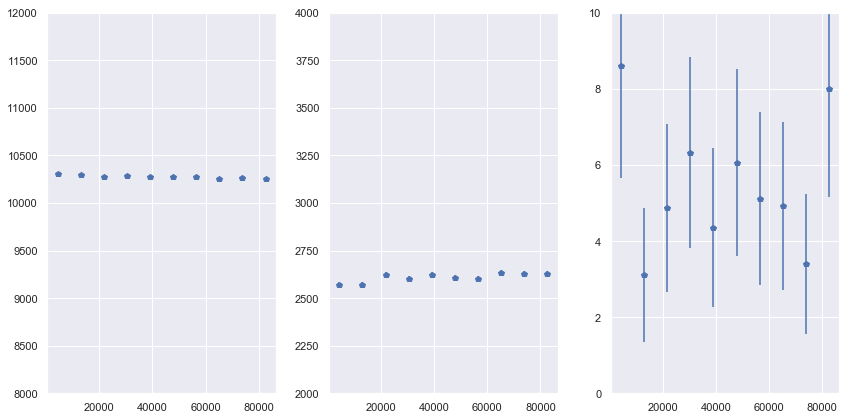

In [38]:
plot_time_fcs(fps,
              range_chi2  = (0,10),
              range_e0    = (8000,12000),
              range_lt    = (2000, 4000),
              figsize     = (12,6))

In [39]:
t0 = time.time()
fpu = time_fcs(ts, masks, kge, 
               nbins_z = 10,
               nbins_e = 25,
               range_z = (50, 550),
               range_e = (5000, 13500),
               energy  = 'S2e',
               fit     = FitType.unbined)
t1 = time.time()
print(f' time_fcs: t = {t1 -t0}')

 time_fcs: t = 0.4284651279449463


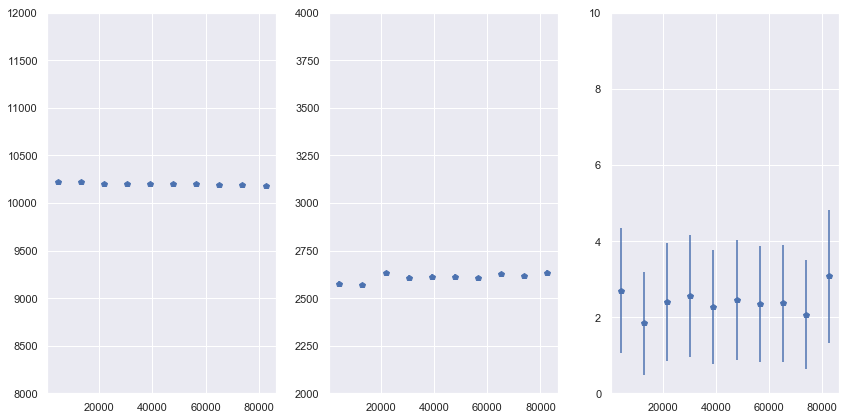

In [40]:
plot_time_fcs(fpu,
              range_chi2  = (0,10),
              range_e0    = (8000,12000),
              range_lt    = (2000, 4000),
              figsize     = (12,6))

In [41]:
abs(fps.e0 - fpu.e0) / fps.e0

array([0.00742781, 0.00699855, 0.00760693, 0.00766067, 0.00697286,
       0.00754073, 0.00732701, 0.00690592, 0.00686452, 0.00737349])

In [42]:
abs(fps.lt - fpu.lt) / fps.lt

array([0.00138618, 0.00151987, 0.00272607, 0.00337806, 0.00315251,
       0.00228243, 0.00116693, 0.00302129, 0.00459903, 0.00096315])

In [43]:
np.allclose(fps.e0, fpu.e0, rtol=1e-02)

True

In [44]:
np.allclose(fps.lt, fpu.lt, rtol=1e-02)

True

##### The bad chi2 is to be expected because we are computing the average of the lifetime, which however changes considerably as a function of the spatial coordinates. In this run the average lifetime does not change much as a function of time

### Function (analysis_functions):
```
select_xy_sectors(dst        : DataFrame,
                  time_diffs : np.array,
                  E          : np.array,
                  Q          : np.array,
                  bins_x     : np.array,
                  bins_y     : np.array)-> Dict[int, List[KrEvent]]
```


In [45]:
log.setLevel(logging.DEBUG)

In [46]:
kTimes, kRanges, kNbins, kBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 5,
                                                        ynbins    = 5,
                                                        znbins    = 10,
                                                        s2enbins  = 25,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) #

In [47]:
print(f' nbins_x = {kNbins.X}, nbins_y = {kNbins.Y}')
print(f' bins_x =  {kBins.X},  bins_y = {kBins.Y}')

 nbins_x = 5, nbins_y = 5
 bins_x =  [-200. -120.  -40.   40.  120.  200.],  bins_y = [-200. -120.  -40.   40.  120.  200.]


In [51]:
t0 = time.time()
KRE = select_xy_sectors(dst, DT, dst.S2e.values, dst.S2q.values, kBins.X, kBins.Y)
t1 = time.time()
print(f' time_fcs: t = {t1 -t0}')                   

2018-10-07 18:07:00,996 | DEBUG :  function: select_xy_sectors
2018-10-07 18:07:00,997 | DEBUG :  calling selection_mask
2018-10-07 18:07:00,999 | DEBUG : computing selection mask for sector 0
2018-10-07 18:07:01,033 | DEBUG : computing selection mask for sector 1
2018-10-07 18:07:01,055 | DEBUG : computing selection mask for sector 2
2018-10-07 18:07:01,072 | DEBUG : computing selection mask for sector 3
2018-10-07 18:07:01,090 | DEBUG : computing selection mask for sector 4
2018-10-07 18:07:01,109 | DEBUG :  selection mask computed, filling selections
2018-10-07 18:07:01,110 | DEBUG :  defining kr_event for sector 0
2018-10-07 18:07:01,251 | DEBUG :  defining kr_event for sector 1
2018-10-07 18:07:01,446 | DEBUG :  defining kr_event for sector 2
2018-10-07 18:07:01,644 | DEBUG :  defining kr_event for sector 3
2018-10-07 18:07:01,826 | DEBUG :  defining kr_event for sector 4
2018-10-07 18:07:01,956 | DEBUG :  RGES computed
 time_fcs: t = 0.9857368469238281


In [52]:
neM = event_map(KRE)

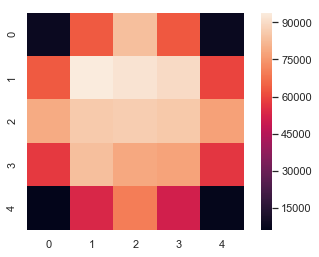

In [53]:
ax = sns.heatmap(neM, square=True)

In [54]:
neM

,0,1,2,3,4
0,8386,63278,83789,63063,8199
1,63604,93863,92090,89802,59750
2,79270,86192,86909,85937,77347
3,57746,83659,78413,77645,56875
4,5877,53407,69962,51379,6724


In [55]:
neM[0]/neM[4]

0    1.022808
1    1.064502
2    1.024862
3    1.015314
4    0.874033
dtype: float64

In [56]:
neM[1]/neM[3]

0    1.003409
1    1.045222
2    1.002967
3    1.077455
4    1.039471
dtype: float64

In [57]:
l = ((neM[0]/neM[4]).values > 0.8).all() 
r = ((neM[0]/neM[4]).values < 1.1).all()
l & r

True

### Function:
```
def fit_fcs_in_xy_bin (xybin         : Tuple[int, int],
                       selection_map : Dict[int, List[KrEvent]],
                       event_map     : DataFrame,
                       n_time_bins   : int,
                       time_diffs    : np.array,
                       nbins_z       : int,
                       nbins_e       : int,
                       range_z       : Tuple[float, float],
                       range_e       : Tuple[float, float],
                       energy        : str                 = 'S2e',
                       fit           : FitType             = FitType.profile,
                       n_min         : int                 = 100)->FitParTS:
```

In [62]:
fps_p = fit_fcs_in_xy_bin (xybin          = (2,2),
                         selection_map   = KRE,
                         event_map       = neM,
                        n_time_bins     = 1,
                        time_diffs      = DT,
                        nbins_z          = 25,
                        nbins_e          = 50,
                        range_z          =(50, 550),
                        range_e          = (5000, 13500),
                        energy           = 'S2e',
                        fit              = FitType.profile,
                        n_min            = 100)

2018-10-07 19:10:23,799 | DEBUG : function: fit_fcs_in_xy_bin: fitting bin (2,2)
2018-10-07 19:10:23,801 | DEBUG : function: get_time_series
2018-10-07 19:10:23,801 | DEBUG :  number of time bins = 1, t_last = 86880.49799990654
2018-10-07 19:10:23,802 | DEBUG : indx = [(0, 86880)]
2018-10-07 19:10:23,803 | DEBUG : ts = [43440.0]
2018-10-07 19:10:23,806 | DEBUG : function:time_fcs 
2018-10-07 19:10:23,807 | DEBUG :  list of kre_event has length 1
2018-10-07 19:10:23,808 | DEBUG :  mask 0 has length 86909
2018-10-07 19:10:23,809 | DEBUG :  mask 0 has 86908 True elements
2018-10-07 19:10:23,810 | DEBUG :  fit_liftime 
2018-10-07 19:10:23,810 | DEBUG :  len (z) =86908, len (e) =86908 
2018-10-07 19:10:23,811 | DEBUG :  nbins_z =25, nbins_e =50 range_z =(50, 550) range_e =(5000, 13500) 
2018-10-07 19:10:23,812 | DEBUG :  fit_liftime_profile
2018-10-07 19:10:23,812 | DEBUG :  len (z) =86908, len (e) =86908 
2018-10-07 19:10:23,813 | DEBUG :  nbins_z =25, range_z =(50, 550) 
2018-10-07 19:10:

In [63]:
fps_u = fit_fcs_in_xy_bin (xybin          = (2,2),
                         selection_map   = KRE,
                         event_map       = neM,
                        n_time_bins     = 1,
                        time_diffs      = DT,
                        nbins_z          = 25,
                        nbins_e          = 50,
                        range_z          =(50, 550),
                        range_e          = (5000, 13500),
                        energy           = 'S2e',
                        fit              = FitType.unbined,
                        n_min            = 100)

2018-10-07 19:10:33,374 | DEBUG : function: fit_fcs_in_xy_bin: fitting bin (2,2)
2018-10-07 19:10:33,375 | DEBUG : function: get_time_series
2018-10-07 19:10:33,376 | DEBUG :  number of time bins = 1, t_last = 86880.49799990654
2018-10-07 19:10:33,376 | DEBUG : indx = [(0, 86880)]
2018-10-07 19:10:33,377 | DEBUG : ts = [43440.0]
2018-10-07 19:10:33,383 | DEBUG : function:time_fcs 
2018-10-07 19:10:33,384 | DEBUG :  list of kre_event has length 1
2018-10-07 19:10:33,385 | DEBUG :  mask 0 has length 86909
2018-10-07 19:10:33,386 | DEBUG :  mask 0 has 86908 True elements
2018-10-07 19:10:33,386 | DEBUG :  fit_liftime 
2018-10-07 19:10:33,387 | DEBUG :  len (z) =86908, len (e) =86908 
2018-10-07 19:10:33,388 | DEBUG :  nbins_z =25, nbins_e =50 range_z =(50, 550) range_e =(5000, 13500) 
2018-10-07 19:10:33,389 | DEBUG :  fit_liftime_unbined
2018-10-07 19:10:33,390 | DEBUG :  len (z) =86908, len (e) =86908 
2018-10-07 19:10:33,390 | DEBUG :  nbins_z =25, range_z =(50, 550) 
2018-10-07 19:10:

In [67]:
log.setLevel(logging.INFO)

In [68]:
neM.shape

(5, 5)

In [69]:
fpmxy = fit_map_xy(selection_map = KRE,
                   event_map     = neM,
                   n_time_bins   = 1,
                   time_diffs    = DT,
                   nbins_z       = 25,
                   nbins_e       = 50,
                   range_z       =(50, 550),
                   range_e       = (5000, 13500),
                   energy        = 'S2e',
                   fit           = FitType.profile,
                   n_min         = 100)

In [83]:
fumxy = fit_map_xy(selection_map = KRE,
                   event_map     = neM,
                   n_time_bins   = 1,
                   time_diffs    = DT,
                   nbins_z       = 25,
                   nbins_e       = 50,
                   range_z       =(50, 550),
                   range_e       = (5000, 13500),
                   energy        = 'S2e',
                   fit           = FitType.unbined,
                   n_min         = 100)

In [81]:
def get_maps_t0(fmxy):
    pE0 = {}
    pLT = {}
    pC2 = {}
    for nx in fmxy.keys():
        pE0[nx] = [fmxy[nx][ny].e0[0] for ny in range(len(fmxy[nx]))] # notice [0] ts bin
        pLT[nx] = [fmxy[nx][ny].lt[0] for ny in range(len(fmxy[nx]))]
        pC2[nx] = [fmxy[nx][ny].c2[0] for ny in range(len(fmxy[nx]))]
    
    return pd.DataFrame.from_dict(pE0), pd.DataFrame.from_dict(pLT),pd.DataFrame.from_dict(pC2)

    

In [82]:
t0 = time.time()
mE0p, mLTp, mC2p = get_maps_t0(fpmxy)
t1 = time.time()
print(f' dt = {t1 -t0}')

 dt = 0.0018451213836669922


In [85]:
t0 = time.time()
mE0u, mLTu, mC2u = get_maps_t0(fumxy)
t1 = time.time()
print(f' dt = {t1 -t0}')

 dt = 0.0016939640045166016


In [324]:
t0 = time.time()
mE0p, mLTp, mC2p = get_maps(fit= FitType.profile)
t1 = time.time()
print(f' dt = {t1 -t0}')

 dt = 0.22681927680969238


In [325]:
t0 = time.time()
mE0u, mLTu, mC2u = get_maps(fit= FitType.unbined)
t1 = time.time()
print(f' dt = {t1 -t0}')

 dt = 0.4076199531555176


In [86]:
mLTp

,0,1,2,3,4
0,2947.580039,2609.216030,2521.439358,2583.548853,2771.378316
1,2551.737036,2298.241281,2280.206687,2281.064699,2524.303344
2,2514.860936,2312.324635,2319.596409,2301.680776,2527.926725
3,2729.889193,2431.629580,2376.429515,2412.970490,2736.942339
4,3228.117789,3001.845473,2845.731932,3035.829600,3138.950379


In [87]:
mLTu

,0,1,2,3,4
0,2980.896948,2622.260828,2532.493142,2592.045930,2784.948557
1,2545.316433,2288.548216,2271.258360,2270.966506,2526.152952
2,2513.557341,2304.150122,2311.793990,2295.235259,2524.105845
3,2735.627579,2426.207961,2370.529889,2408.548274,2729.494455
4,3277.475619,3021.021177,2855.343131,3024.519157,3141.156095


In [88]:
mLTp / mLTu

,0,1,2,3,4
0,0.988823,0.995025,0.995635,0.996722,0.995127
1,1.002523,1.004235,1.003940,1.004447,0.999268
2,1.000519,1.003548,1.003375,1.002808,1.001514
3,0.997902,1.002235,1.002489,1.001836,1.002729
4,0.984940,0.993653,0.996634,1.003740,0.999298


In [93]:
r1 = (mLTp / mLTu).values

In [104]:
l1 = np.allclose(r1, 1, rtol=1e-01)

In [97]:
r2 = mE0p / mE0u

In [111]:
l2 = np.allclose(r2, 1, rtol=1e-02)

In [112]:
l2

True

In [113]:
l1 & l2

True

In [91]:
mC2p / mC2u

,0,1,2,3,4
0,1.430154,1.618386,1.607175,1.660206,1.224398
1,1.631746,1.707023,1.659645,1.978082,1.213569
2,1.548231,1.855896,1.451242,2.138199,1.860764
3,0.997409,1.545262,0.908582,1.271424,1.338186
4,1.513029,1.737253,1.725130,1.506256,1.152628


In [ ]:
l = ((neM[0]/neM[4]).values > 0.8).all() 
r = ((neM[0]/neM[4]).values < 1.1).all()
l & r